# Checkpoint 1
---
**Group 1: Haseeb Asim, Chloé Blanchard, Olatoyosi Fatoki**

*from Professor Ritter, Columbia Unviersity 5440 Course Notes*

### Setup
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols 
from scipy.stats import gaussian_kde 
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import os

In [ ]:
os.getcwd()

'/content'

In [ ]:
model_dir = '/Users/haseebasim/Google Drive/Documents/APANPS5440_Project/' 

def sort_cols(test):
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2003,2004,2005,2006,2007,2008,2009,2010]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load( bz2.open( fil, "rb" ) ))

### Problem 1
---

In [ ]:
for x in frames:
    frames[x] = sort_cols(frames[x])

covariance = {}
for year in [2003,2004,2005,2006,2007,2008,2009,2010]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pickle.load( bz2.open(fil, "rb" ) ))

### Problem 2
---

In [ ]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

### Problem 3
---

In [ ]:
def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    return df

### Problem 4
---

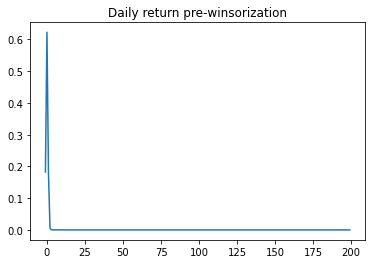

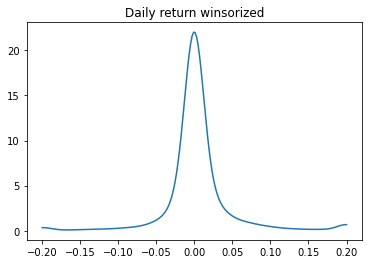

In [ ]:
def density_plot(data, title):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200) 
    density.covariance_factor = lambda : .25 
    density._compute_covariance() 
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')


*Q: Why might it be important to re-run this after passing it through bounds of b = -0.2 and b = 0.2 when running a regression with "Ret" as the "Y variable"?*

**A: Winsorized estimators are usually more robust to outliers than their more standard forms. Before any kind of winsorization, the returns can be observed to have a very heavy right tail. We therefore want to run the data through a bounded domain of length 1 here so as to normalize our data and generate results that are robust to the particular skew to the RHS.**

# Checkpoint 2
---
**Group 1: Haseeb Asim, Chloé Blanchard, Olatoyosi Fatoki**

### Problem 1
---

In [ ]:
def get_formula(factors, Y): 
    L = ["0"]
    L.extend(factors)
# print(L)
    return Y + " ~ " + " + ".join(L)

In [ ]:
def estimate_factor_returns(df):
   # rename df columns
    df = df.rename(columns = {'1DREVRSL' : 'ONEDREVERSAL', 'EARNYILD' : 'EARNYIELD', 'SENTMT' : 'SENTIMENT'})
    
    ## build universe based on filters
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    
    ## winsorize returns for fitting
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
#     print(list(df))
#     all_factors = factors_from_names(list(df))
    all_factors = ['ONEDREVERSAL','EARNYIELD', 'VALUE', 'SENTIMENT'] 
#     print(all_factors)
    form = get_formula(all_factors, "Ret")
    model = ols(form, data=estu)
    results = model.fit()
    return(results)

### Problem 2
---

In [ ]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

<AxesSubplot:>

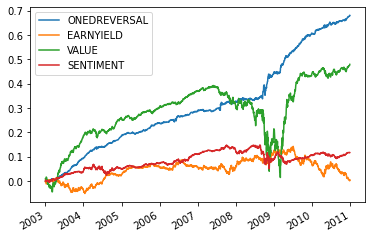

In [ ]:
alpha_factors = ['ONEDREVERSAL','EARNYIELD', 'VALUE', 'SENTIMENT'] 
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'),frames.keys())))

facret_df = pd.DataFrame(index = my_dates) 
for dt in my_dates:
     for alp in alpha_factors:
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

facret_df.cumsum().plot()